## LDA Topic Modeling

Topic modelling is a technique to extract hidden topics from large volume of text. LDA represents topics as word probabilities and allows for uncovering hidden topics as it clusters words based ontheir co-occurrence in a respective document.

### Assumptions for LDA
1. Documents with similar topics use similar groups of words
2. Latent topics can be found by searching for groups of words that frequently occur together in documents across corpus
3. Documents are probability distributions over latent topics that signifies certain document will contain more words of specific topic
4. Topics themselves are probability distribution over words

### Goal: To find out what users speak about

One can use any vectorizer and not just count vectorizer e.g. tfidf - experiment!

### Steps that we will follow are below:
1. Get the data
2. Data cleaning
3. Get the tokens
4. 

In [72]:
# Setting to ignore warnings
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 150)

In [73]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Text processing libraries
import re
from nltk.corpus import stopwords
import emoji
import contractions  # from https://github.com/kootenpv/contractions
import string


In [74]:
# Read data and clean a bit
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
data_in = spotify.copy()
data_in = data_in.drop_duplicates(subset="Review")  # Drop dupes in Reviews
data_in.drop(["Time_submitted", "Total_thumbsup",
             "Reply"], axis=1, inplace=True)
data_in["Length"] = data_in["Review"].str.split(" ").str.len()
data_in = data_in[data_in.Length < 150]
data_in.drop(["Length"], axis=1, inplace=True)
data = data_in
data.head(10)

,Review,Rating
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",5
1,Please ignore previous negative rating. This app is super great. I give it five stars+,5
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,1
5,The player controls sometimes disappear for no reason. App restart forgets what I was playing but fixes the issue.,3
6,I love the selection and the lyrics are provided with the song you're listening to!,5
7,"Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done N...",3
8,"It's a great app and the best mp3 music app I have ever used but there is one problem that, why can't we play some songs or find some songs? despi...",5
9,"I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consu...",1


### Clean data

In [75]:
## Define a function to do some text cleaning
def clean_text(text):
    text = emoji.demojize(text)  # fix emojis
    text = contractions.fix(text)  # fix contractions
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # remove strange fonts
    text = re.sub(r"\d+", "number", text)  # replace numbers with "number"
    text = re.sub(r'[^\w\s]', '', text)  # remove non-alphanumeric chars
    text = re.sub(r'\b\w{1}\b', '', text) # remove words less than 1 character
    text = text.replace('_', ' ')  # replace underscores with space
    text = text.strip()  # strip extra spaces
    return text.lower()

In [76]:
## Test our text cleaner
clean_text("I ❤️ Spotify, even though it is critizised for exploiting artists")

'red heart spotify even though it is critizised for exploiting artists'

In [77]:
## Apply to all data
data["Review"] = data["Review"].apply(clean_text)

In [78]:
## Tokenize/remove punctuations
tokenizer = RegexpTokenizer(r'\w+')

In [79]:
data["Tokens"] = data["Review"].apply(tokenizer.tokenize)

In [80]:
data.sample(10)

,Review,Rating,Tokens
43185,want to download whole albums but on my samsung galaxy snumber lite cannot also it keeps shuffling songs even though do not have shuffle on also...,3,"[want, to, download, whole, albums, but, on, my, samsung, galaxy, snumber, lite, cannot, also, it, keeps, shuffling, songs, even, though, do, not,..."
58047,the very thing to help me disconnect from real world and focus on my work by listening to music guess it really help me go through the day every ...,5,"[the, very, thing, to, help, me, disconnect, from, real, world, and, focus, on, my, work, by, listening, to, music, guess, it, really, help, me, g..."
23125,it is good song app it has playlist you can make some playlists of your own if you are in to new songs they recommend songs every day and you get...,4,"[it, is, good, song, app, it, has, playlist, you, can, make, some, playlists, of, your, own, if, you, are, in, to, new, songs, they, recommend, so..."
7317,most of the music of the world you can find student deals on premium are blessing,5,"[most, of, the, music, of, the, world, you, can, find, student, deals, on, premium, are, blessing]"
52781,they just need to do that make songs playable but some are not playable,4,"[they, just, need, to, do, that, make, songs, playable, but, some, are, not, playable]"
16821,amazing app in time pass can hear music also and also it support ncs yay boi and this app is noice,1,"[amazing, app, in, time, pass, can, hear, music, also, and, also, it, support, ncs, yay, boi, and, this, app, is, noice]"
6049,good application for lovers of music,5,"[good, application, for, lovers, of, music]"
5605,smart music app excellent,5,"[smart, music, app, excellent]"
317,the main problem for me it is the absence of belarusian language it would be great to use the app in my lang,4,"[the, main, problem, for, me, it, is, the, absence, of, belarusian, language, it, would, be, great, to, use, the, app, in, my, lang]"
16862,so amazing and love the way it functions it is so awesome thanks for this amazing apphufflpuff,5,"[so, amazing, and, love, the, way, it, functions, it, is, so, awesome, thanks, for, this, amazing, apphufflpuff]"


In [81]:
# Get NLTK English stopwords
our_stopwords = set(stopwords.words('english'))
additional_stopwords = ["spotify", "app", "apps", "cannot", "like", "love", "much", "many"]
for word in additional_stopwords:
    our_stopwords.add(word)
#our_stopwords.remove("not")
# Remove stopwords
# We loop through each list of words and remove stopwords
data['Tokens'] = data['Tokens'].apply(lambda x: [word for word in x if word not in (our_stopwords)])
data.sample(5)

,Review,Rating,Tokens
19626,it keeps pausing while to listening to music it angers me because it pauses in the middle of song after every freaking second do not recommend t...,1,"[keeps, pausing, listening, music, angers, pauses, middle, song, every, freaking, second, recommend, stupid]"
16947,am literally trying to play song but it chooses it is own song chappy app sucks balls,1,"[literally, trying, play, song, chooses, song, chappy, sucks, balls]"
21815,love this app for the sake of use it heavily since can connect it to my console and use it on my phone as well it has wide range of music and ...,5,"[sake, use, heavily, since, connect, console, use, phone, well, wide, range, music, bunch, songs, countless, problem, lies, within, able, see, son..."
26268,the app works well for years until last monththe music plays for number mins and then stop and sometime only number seconds and then stopi have cl...,2,"[works, well, years, last, monththe, music, plays, number, mins, stop, sometime, number, seconds, stopi, closed, open, change, tracks, continue, w..."
27506,would be number stars except for the new update that makes it always want to connect to bluetooth which may have resulted in the fact it no longer...,4,"[would, number, stars, except, new, update, makes, always, want, connect, bluetooth, may, resulted, fact, longer, works, perfectly, eg, randomly, ..."


In [82]:
## Split data in train and test
X_train, X_test = train_test_split(data['Tokens'], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)

(46009,) (15337,)


In [83]:
## Count Vectorizer
def dummy(doc):
    return doc

count_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_features = 10000, ngram_range = (1,3))

X_train_counts = count_vectorizer.fit_transform(X_train)

In [84]:
## make TFIDF matrix
tfidf_vectorizer = TfidfTransformer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_counts)

In [85]:
## Get number of features from vectorizer and it shall match number of features that we provide to it
len(count_vectorizer.get_feature_names())

10000

In [86]:
## Fit model
LDA = LatentDirichletAllocation(n_components=4,random_state=42)
LDA.fit(X_train_tfidf)

LatentDirichletAllocation(n_components=4, random_state=42)

In [87]:
## Number of components (=topics)
n_components = len(LDA.components_)
print("Number of components: ", n_components)

Number of components:  4


In [88]:
#
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([count_vectorizer.get_feature_names()[index] for index in (-topic).argsort()[:15]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['songs', 'song', 'playlist', 'want', 'listen', 'play', 'shuffle', 'number', 'add', 'music', 'even', 'good', 'plays', 'one', 'playlists']


THE TOP 15 WORDS FOR TOPIC #1
['music', 'ads', 'best', 'good', 'great', 'number', 'best music', 'premium', 'quality', 'songs', 'ever', 'better', 'streaming', 'really', 'every']


THE TOP 15 WORDS FOR TOPIC #2
['playing', 'update', 'fix', 'number', 'play', 'phone', 'time', 'stop', 'keeps', 'music', 'please', 'even', 'working', 'work', 'song']


THE TOP 15 WORDS FOR TOPIC #3
['music', 'easy', 'face', 'use', 'great', 'listening', 'easy use', 'good', 'account', 'smiling', 'listen', 'favorite', 'find', 'podcasts', 'songs']




In [89]:
## Let's give a descriptive name to the topics
lda_topics = ['fix_update_phone', 'spotify_is_awesome', 'please_fix_something', 'ads_and_premium']

In [90]:
def get_model_topics(model, vectorizer, topics, n_top_words=10):    
    word_dict = {}    
    feature_names = vectorizer.get_feature_names()    
    for topic_idx, topic in enumerate(model.components_):        
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]        
        top_features = [feature_names[i] for i in top_features_ind]        
        word_dict[topics[topic_idx]] = top_features
    return pd.DataFrame(word_dict)

In [91]:
get_model_topics(LDA, count_vectorizer, lda_topics)

,fix_update_phone,spotify_is_awesome,please_fix_something,ads_and_premium
0,songs,music,playing,music
1,song,ads,update,easy
2,playlist,best,fix,face
3,want,good,number,use
4,listen,great,play,great
5,play,number,phone,listening
6,shuffle,best music,time,easy use
7,number,premium,stop,good
8,add,quality,keeps,account
9,music,songs,music,smiling


In [92]:
topic_results = LDA.transform(X_train_tfidf)

In [93]:
# Split original data
data_train, _ = train_test_split(data, test_size=0.25, random_state=42)

In [94]:
pd.set_option('display.max_colwidth', 150)
data_train['Topic_number'] = topic_results.argmax(axis=1)
data_train[["Review", "Topic_number"]].sample(10)

,Review,Topic_number
4396,it works really good when listen to it through my head band and through my tablet even when am in an area with no wifi it still works great this...,0
40195,tysm am able to make playlist of my favorite artists and listen to it all day and night if possible uninterrupted songs with premium plansblue h...,3
30216,bad update it is been over week and it crashes completely,2
9937,always recommended but you always need strong internet to play songs,2
47423,increasingly pushy with ads even to paid subscriber first party advertising is just as annoying as third party advertising,2
27460,my shuffle button does not work have installed and deleted and installed several times and the problem persist have tried everything could find...,2
37029,spotify is my lifes recipeit makes it delicious colourful and wonderful with spotify am not alone,3
36723,the newest update is horrendous multiple times day will go to play song and it just does not show up at the bottom meaning can see the nextpre...,2
46111,lately some podcasts episodes do not play or take too long to start this is kind of frustrating,2
53649,love it however wish you did not have to pay to be allowed to download songs wish it was completely free app do love how it is set up and it i...,0


In [95]:
LDA.perplexity(X_train_counts)

2056.1000486410803

In [96]:
LDA.score(X_train_counts)

-6698415.199785476

In [97]:
def assign_topic_name(topic_number):
    if topic_number == 0:
        return lda_topics[0]
    if topic_number == 1:
        return lda_topics[1]
    if topic_number == 2:
        return lda_topics[2]
    if topic_number == 3:
        return lda_topics[3]
    if topic_number == 4:
        return lda_topics[4]


data_train["Topic_name"] = data_train["Topic_number"].apply(assign_topic_name)

In [98]:
data_train.sample(10)

,Review,Rating,Tokens,Topic_number,Topic_name
38286,black screen appear everytime any link is clicked to redirect to app to play the song just have to type in search bar there tried everything from ...,1,"[black, screen, appear, everytime, link, clicked, redirect, play, song, type, search, bar, tried, everything, reinstalling, switching, account, st...",2,please_fix_something
18505,third grade application it keeps on hanging and lagging everything is working fine but this damn application worst experience ever,1,"[third, grade, application, keeps, hanging, lagging, everything, working, fine, damn, application, worst, experience, ever]",2,please_fix_something
46178,love how few ads get as apposed too yt music wish could playback though,5,"[ads, get, apposed, yt, music, wish, could, playback, though]",0,fix_update_phone
30097,have two stars because when quit the app with songs the songs stop and when am replay the song again it stops so fix it before number week or el...,2,"[two, stars, quit, songs, songs, stop, replay, song, stops, fix, number, week, else, number, number, star]",2,please_fix_something
11603,love this app red heartsmiling face with sunglasses surely recommend it to all age groups walks of life thumbs up,5,"[red, heartsmiling, face, sunglasses, surely, recommend, age, groups, walks, life, thumbs]",3,ads_and_premium
3361,when it says free premium for month it should mean free premium for month not sign up for spotify premium that does not make sense and you shoul...,1,"[says, free, premium, month, mean, free, premium, month, sign, premium, make, sense, wait, skips, need, remove, songs, added, hate, songs, added]",0,fix_update_phone
45168,update it is fixed now and the rude judgemental advertisements have stopped it logs me out on its own and then creates lot of fuss like it does n...,3,"[update, fixed, rude, judgemental, advertisements, stopped, logs, creates, lot, fuss, let, log, shows, error, sending, link, shows, attempt, shows...",3,ads_and_premium
34555,lately the app works really bad if it keeps getting worse might cancel my premium account,2,"[lately, works, really, bad, keeps, getting, worse, might, cancel, premium, account]",2,please_fix_something
39019,turns off randomly the playbar is gone so no way to stopstart or rewindff,1,"[turns, randomly, playbar, gone, way, stopstart, rewindff]",2,please_fix_something
54783,it is good and love it but hate the fact that we have to pay for premium to play the songs in playlist in order nownot to mention we cannot tur...,2,"[good, hate, fact, pay, premium, play, songs, playlist, order, nownot, mention, turn, shuffle]",0,fix_update_phone


In [99]:
topic_f = pd.DataFrame(data_train["Topic_name"].value_counts()).reset_index()
topic_f.columns = ["Topic_name", "Count"]
topic_f

,Topic_name,Count
0,please_fix_something,14909
1,spotify_is_awesome,11571
2,fix_update_phone,10516
3,ads_and_premium,9013


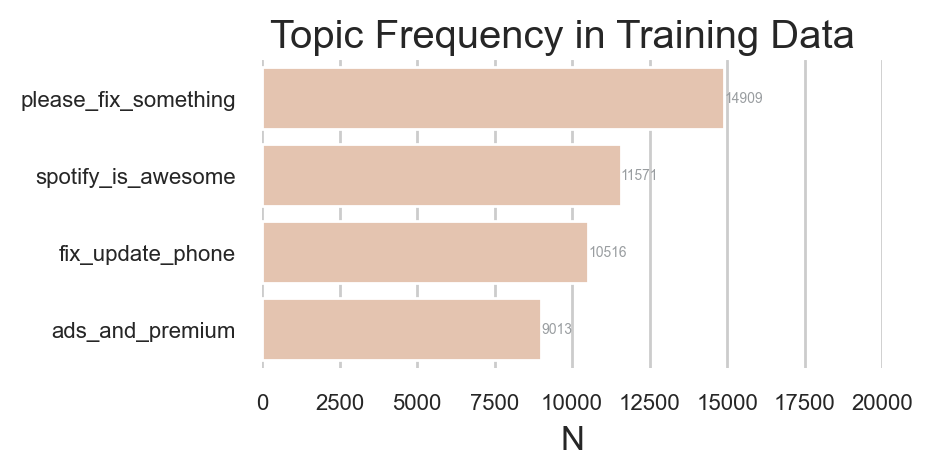

In [100]:
## Plot per country
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(4,2),dpi=200)

sns.set_color_codes("pastel")
sns.barplot(x="Count", 
            y="Topic_name", 
            data=topic_f,
            color = "#EDC2A7")

ax.set(xlim=(0, 20000), ylabel="",
       xlabel="N")
ax.bar_label(ax.containers[0], size=5, label_type="edge", padding=0, color="#999DA0")
plt.suptitle("Topic Frequency in Training Data")

ax.tick_params(labelsize=8)

sns.despine(left=True, bottom=True)

In [115]:
# Fit model
perplexities = []
scores = []
n_topics = range(4,10,2)
for n_topic in n_topics:
    LDA = LatentDirichletAllocation(n_components=n_topic,random_state=42)
    LDA.fit(X_train_counts)

    perplexities.append(LDA.perplexity(X_train_counts))
    scores.append(LDA.score(X_train_counts))

In [116]:
perplexities

[1847.4418684814796,
 1699.8691180880644,
 1685.8197927106337,
 1678.3319170079221,
 1696.3191762504246,
 1703.5521668738118,
 1724.9449675870972,
 1747.9937356545277,
 1762.720677701045,
 1795.1888214565283,
 1795.6188686925955,
 1834.7548593065906,
 1857.605316869742,
 1867.5699962552817,
 1938.417566156843,
 1925.3066575934574,
 1947.0001284593236,
 1959.9675494835478,
 2004.5733910985498,
 2034.1414306284294,
 2059.4630814395423,
 2091.3206507002733,
 2086.207934211732,
 2151.220769327041]

In [117]:
scores

[-6604453.719509288,
 -6531353.821576251,
 -6524066.464546372,
 -6520157.669436516,
 -6529518.176261876,
 -6533254.248023013,
 -6544212.180653085,
 -6555867.283522005,
 -6563234.081461606,
 -6579260.399401123,
 -6579470.72064969,
 -6598402.915028641,
 -6609271.062481855,
 -6613968.670600569,
 -6646662.583299526,
 -6640703.390043062,
 -6650541.755800539,
 -6656370.493649668,
 -6676130.009201081,
 -6688987.204369984,
 -6699850.230070896,
 -6713328.997906091,
 -6711179.724661266,
 -6738125.452344715]

In [ ]:
## To-Do
# Topic and its visualization against word > Dominik did
# Check against test data 
# Coherence measure

# Think of considering app as stopword as its present in almost all topics > check if there are more stopwrods to be included

# Make use of time column from data and see how topic changes over time